In [1]:
import pandas as pd
import math
import csv
import json
import string
import re
import utils
import nltk
from collections import Counter
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer #PorterStemmer
from nltk.tokenize import word_tokenize
import plotly.graph_objects as go


# Download stopwords and initialize stemmer
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reggie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/reggie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def get_stemmed_tokens(data_list):
    all_stems = []
  
    for text in data_list:
        text = re.sub(r'\d+', '', text)
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)
        # Tokenize the sentence
        tokens = word_tokenize(text)

        # Remove stopwords and perform stemming
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords and token.isalnum()]
        stems = [stemmer.stem(word) for word in filtered_tokens]
        all_stems += stems
        
    return all_stems

In [3]:
def get_stem_word_dict(data_list, stem_word_dict):
    if not stem_word_dict:
        stem_word_dict = {}
    for text in data_list:
        text = re.sub(r'\d+', '', text)
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)
        # Tokenize the text into individual words
        words = word_tokenize(text)
        # Retrieve the stem for each word
        stems = [stemmer.stem(word) for word in words]
        # Create a dictionary to associate each stem with its corresponding words       
        for word, stem in zip(words, stems):
            stem_word_dict.setdefault(stem, []).append(word)
    
    for key in stem_word_dict.keys():
        vals = stem_word_dict[key]
        stem_word_dict[key] = list(set(vals))        
            
    return stem_word_dict        

In [4]:
def get_words(data_list):
    all_words = []
    for text in data_list:
        text = re.sub(r'\d+', '', text)
        translator = str.maketrans('', '', string.punctuation)
        text = text.translate(translator)
        # Tokenize the text into individual words
        words = word_tokenize(text)
        all_words += words
    return all_words

In [5]:
def get_ngrams(data_list, n):
    words = get_words(data_list)
    ngrams = []
    for i in range(len(words) - n + 1):
        ngram_str = ' '.join(words[i:i+n]).lower()
        ngrams.append(ngram_str)
    return ngrams


In [69]:
def get_dict_counts(tokens, stemmed_seeds):
    counts = np.zeros(len(stemmed_seeds))
    non_tracked_tokens = {}
    # get corpus size from number of ngrams using the formula:
    # corpus_size = no_ngrams + n - 1
    n = len(tokens[0])
    no_ngrams = len(tokens)
    corpus_size = no_ngrams + n - 1
    d = corpus_size/n
    for token in tokens:
        found = False
        for i in range(len(stemmed_seeds)):
            if token in stemmed_seeds[i]:
                counts[i] += 1
                found = True
        if not found:
            non_tracked_tokens.setdefault(token, 0)
            non_tracked_tokens[token] += 1
    norms = [c/d for c in counts if len(tokens) > 0]
    return (counts, norms, non_tracked_tokens)

In [70]:
def get_vocab_counts(tokens):
    vocab_counts = {}
    for token in tokens:
        if token not in vocab_counts.keys():
            vocab_counts[token] = 1
        else:
            vocab_counts[token] += 1
    return dict(sorted(vocab_counts.items(), key=lambda x: x[1], reverse=True))

In [71]:
# load data setof all countries, years and sources
data_file = '../data/all_countries_0.0.2.csv'
countries, years, all_countries_data = utils.get_countries_data(data_file)

In [72]:
# load dictionary of topics
# strcuture [{"name": TOPIC_NAME, "words": NGRAMS_OF_KEYWORDS}, ...]
dict_file = '../data/dict_2.json'
n = 1
dictionary,topics = utils.get_seed_lists(dict_file, n, exact=True )
dictionary = np.squeeze(list(dictionary))
ngram_dict = []
if n == 1:
    ngram_dict = [ list(get_stemmed_tokens(l)) for l in dictionary ]
else:
    ngram_dict = dictionary

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



In [73]:
# iterate countries
year = "2020"
results = {"country": [], "no_words": []}
non_tracked_tokens = {}
stem_word_dict = {}
for i in range(len(ngram_dict)):
    results[i+1] = []
    

for country in countries:
    df = all_countries_data
    country_data = df[(df['year'] == year) & (df['country'] == country)]
    country_data = country_data.reset_index(drop=True)

    # Preprocessed tokens (list of strings)
    data_list = np.squeeze(country_data[["sentence"]].to_numpy())
    if n == 1:
        # Count single ngram
        tokens = get_stemmed_tokens(data_list)
        
        if(len(tokens) == 0):
            continue
       
        stem_word_dict = get_stem_word_dict(data_list, stem_word_dict)
        counts, norms, others = get_dict_counts(tokens, ngram_dict)    
        non_tracked_tokens = dict(Counter(non_tracked_tokens) + Counter(others))   
        if not norms:
            continue    
        results["country"].append(country)
        results["no_words"].append(len(tokens))
        for i in range(len(norms)):
            results[i+1].append(norms[i])
    else:
        # Count ngrams
        ngrams = get_ngrams(data_list, n)
        if(len(ngrams) == 0):
            continue
        counts, norms, others = get_dict_counts(ngrams, ngram_dict)
        if not norms:
            continue    
        results["country"].append(country)
        results["no_words"].append(len(ngrams))
        for i in range(len(norms)):
            results[i+1].append(norms[i])
        


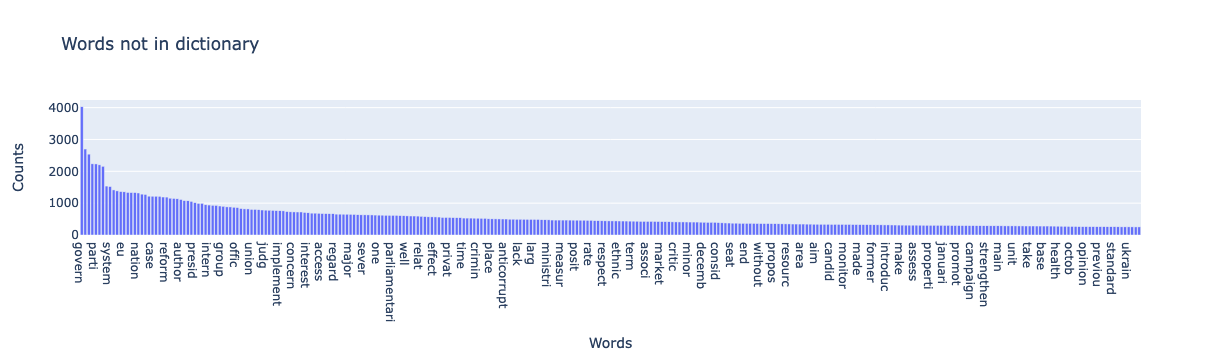

In [74]:
# plot non tracked tokens
sorted_data = sorted(non_tracked_tokens.items(), key=lambda x: x[1], reverse=True)

top = dict(itertools.islice(sorted_data, 300))

x = list(top.keys())
y = list(top.values())

fig = go.Figure(data=go.Bar(x=x, y=y))

# Customize the layout (optional)
fig.update_layout(title='Words not in dictionary', xaxis_title='Words', yaxis_title='Counts')

# Display the chart
fig.show()

In [75]:
with open('missing_words.txt', 'w') as file:    
    for stem in top.keys():
        if stem in stem_word_dict.keys():
            file.write(f'{stem}: {stem_word_dict[stem]}\n')
            #print(f'{stem}: {stem_word_dict[stem]}')
    print("done")

done


In [76]:
df = pd.DataFrame(results)
nc = {}
for i in range(len(topics)):
    nc[i+1] = topics[i]
print(nc)   
df = df.rename(columns=nc)

{1: 'electoral', 2: 'participatory', 3: 'liberal', 4: 'corruption'}


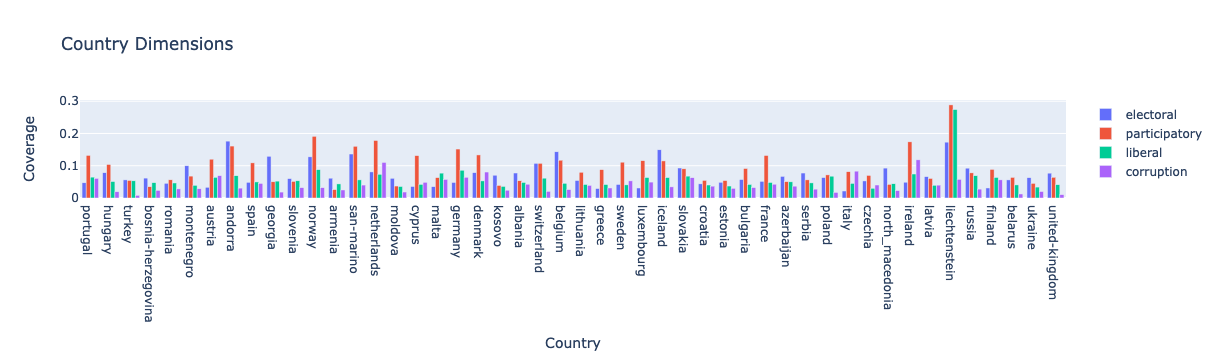

In [77]:
# plot
fig = go.Figure()

# Iterate over each column (excluding the 'Category' column)
for col in df.columns[2:]:
    fig.add_trace(go.Bar(x=df['country'], y=df[col], name=col))

# Customize the layout (optional)
fig.update_layout(title='Country Dimensions', xaxis_title='Country', yaxis_title='Coverage')

# Display the chart
fig.show()



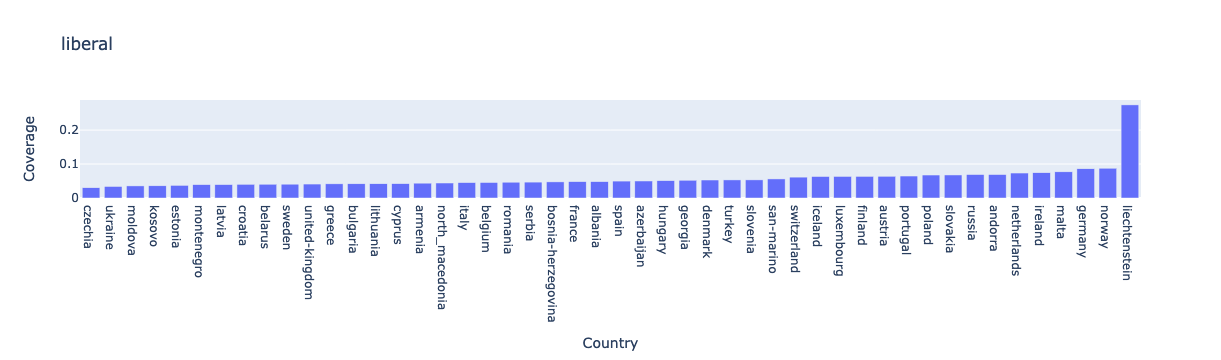

In [78]:
# plot single topic
topic = 'liberal'
df_sorted = df.sort_values(by=topic, ascending=True)
fig = go.Figure(data=[go.Bar(x=df_sorted['country'], y=df_sorted[topic])])

# Customize the layout (optional)
fig.update_layout(title=topic, xaxis_title='Country', yaxis_title='Coverage')

# Display the chart
fig.show()


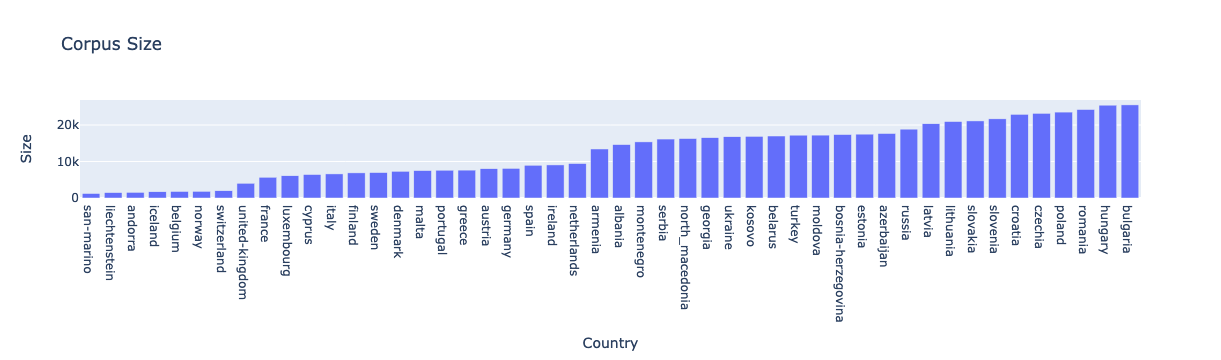

In [24]:
# plot size
df_sorted = df.sort_values(by='no_words', ascending=True)
fig = go.Figure(data=[go.Bar(x=df_sorted['country'], y=df_sorted['no_words'])])

# Customize the layout (optional)
fig.update_layout(title='Corpus Size', xaxis_title='Country', yaxis_title='Size')

# Display the chart
fig.show()